In [2]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

In [3]:
# load data
df = pd.read_excel("../data/raw/Telco_customer_churn_adapted_v2.xlsx")
df['Churn'] = df['Churn Label'].map({"Yes": "1", "No": "0"}).astype(int)

In [4]:
df['Churn Label'].value_counts(normalize=True)*100

Churn Label
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64

26% of passengers churned from purchasing

# Background

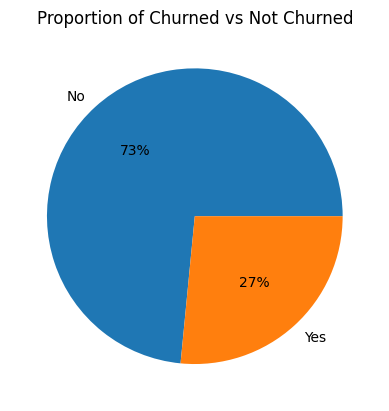

In [5]:
plot_df = df['Churn Label'].value_counts(normalize=True)*100
plt.pie(plot_df, labels=plot_df.index, autopct='%.0f%%')
plt.title("Proportion of Churned vs Not Churned")
plt.show()

26% of passengers churned from purchasing

In [6]:
display(df.groupby("Churn Label")["CLTV (Predicted Thou. IDR)"].sum())
display(df.groupby("Churn Label")["Monthly Purchase (Thou. IDR)"].sum())

Churn Label
No     30206835.1
Yes    10081832.8
Name: CLTV (Predicted Thou. IDR), dtype: float64

Churn Label
No     412081.475
Yes    180870.105
Name: Monthly Purchase (Thou. IDR), dtype: float64

Around `Rp10,081,832,800.00` potential income in the future will be gone.

Around `Rp180,870,800.00` strip out from the company's monthly income.

# What feature that really involve in customer churning?

## Device Class

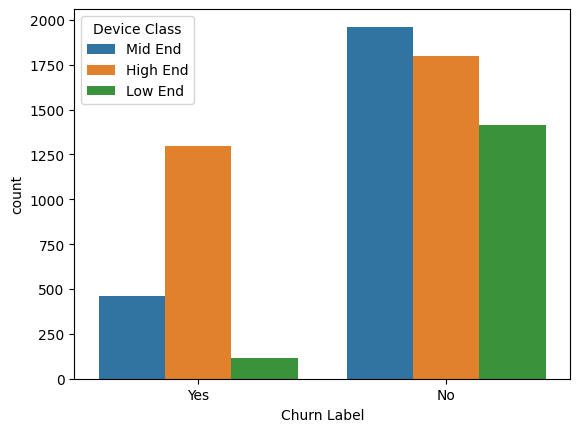

In [7]:
sns.countplot(data=df, x='Churn Label', hue='Device Class')
plt.show()

`~1250` customer who churned are from the high end class followed by mid (`~500`) and low (`~125`) end class.

In [8]:
# df['Churn Label'] = df['Churn Label'].map({"Yes": "1", "No": "0"}).astype(int)
churn_device = df.pivot_table(columns="Device Class", aggfunc={"Churn": np.mean})
churn_device

Device Class,High End,Low End,Mid End
Churn,0.418928,0.07405,0.189591


In [9]:
churn_device = df.pivot_table(index="Device Class", columns='Churn Label', values="Customer ID", aggfunc="count", margins=True)
churn_device = churn_device/churn_device.loc['All', :]
churn_device = churn_device.loc[churn_device.index != 'All', churn_device.columns != 'All']
churn_device

Churn Label,No,Yes
Device Class,,
High End,0.347700,0.693954
Low End,0.273096,0.060460
Mid End,0.379204,0.245586


From all the churned user around 70% are from high end class users, 24% are high end class users, and 6% are from low end class users

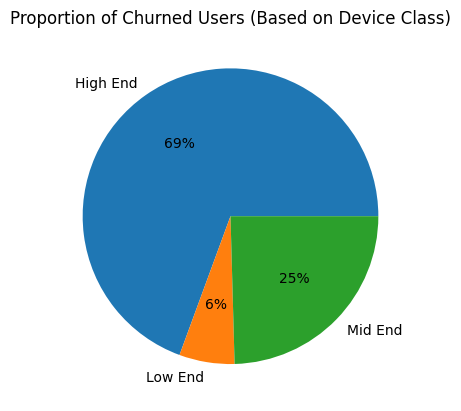

In [10]:
plt.pie(churn_device['Yes'], labels=churn_device.index, autopct='%.0f%%')
plt.title("Proportion of Churned Users (Based on Device Class)")
plt.show()


## Location

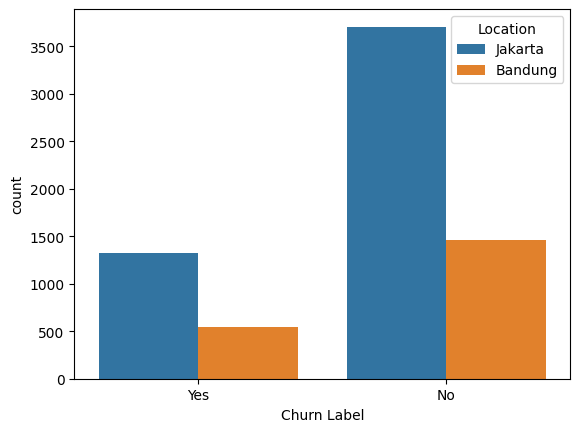

In [11]:
sns.countplot(data=df, x='Churn Label', hue='Location')
plt.show()

`Monthly Purchase (Thou. IDR)` doesn't influence the Churn of customers.

In [12]:
churn_device = df.pivot_table(index="Location", columns='Churn Label', values="Customer ID", aggfunc="count", margins=True)
churn_device = churn_device/churn_device.loc['All', :]
churn_device = churn_device.loc[churn_device.index != 'All', churn_device.columns != 'All']
churn_device = 

Churn Label,No,Yes
Location,,
Bandung,0.28334,0.292135
Jakarta,0.71666,0.707865


Churned customers 70% are located in Jakarta. But I think there's no way that location correlates with the churn

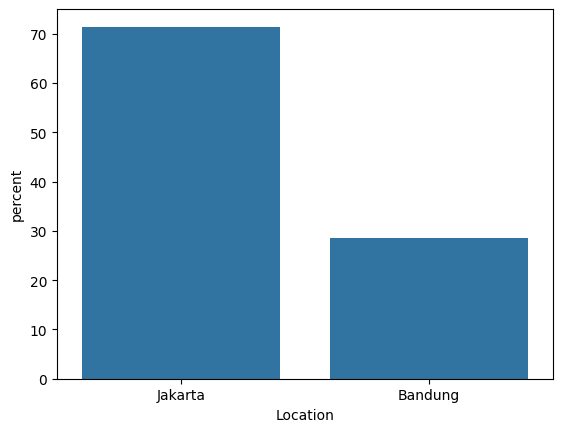

In [13]:
sns.countplot(data=df, x='Location', stat='percent')
plt.show()

This is not fair because around 70% are users from Jakarta

## Games Product, Music Product, Education Product, Call Center, Video Product, and Use MyApp

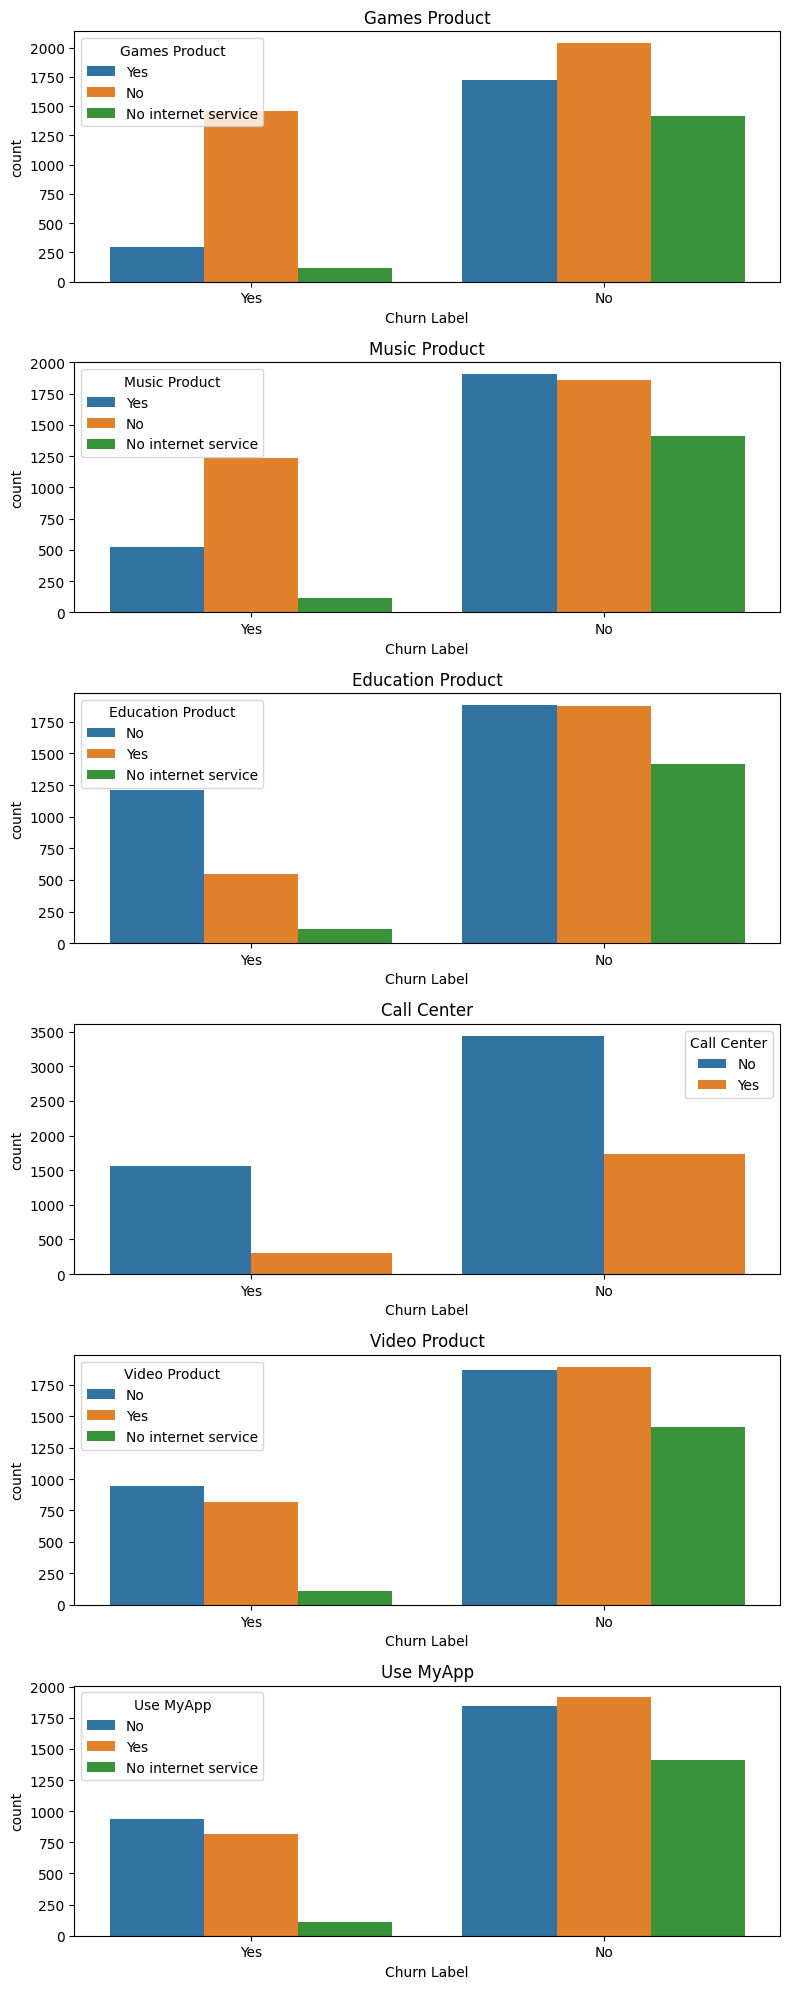

In [14]:
cols = ["Games Product", "Music Product", "Education Product", "Call Center", "Video Product", "Use MyApp"]
fig, ax = plt.subplots(nrows=len(cols), figsize=(8, 20))
for i, c in enumerate(cols):
    sns.countplot(data=df, x='Churn Label', hue=c, ax=ax[i])
    ax[i].set_title(c)
fig.tight_layout()

High End Device Users has more likely change to churn

## Payment Method

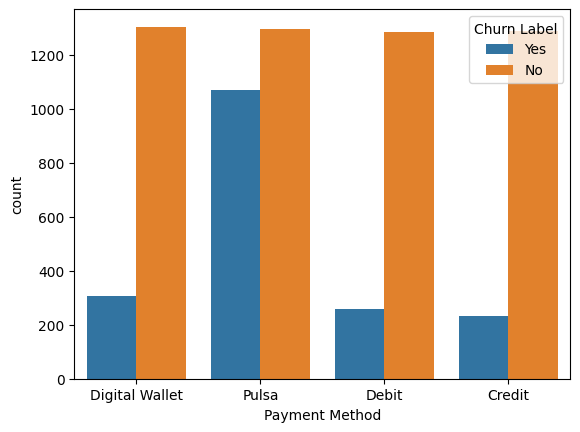

In [17]:
sns.countplot(data=df, x='Payment Method', hue='Churn Label')
plt.show()

In [28]:
churn_payment_method = df.pivot_table(columns="Payment Method", index="Churn", values="Customer ID", aggfunc="count", margins=True)
churn_payment_method /= churn_payment_method.loc['All', :]
churn_payment_method = churn_payment_method.loc[churn_payment_method.index != 'All', churn_payment_method.columns != 'All']
churn_payment_method

Payment Method,Credit,Debit,Digital Wallet,Pulsa
Churn,,,,
0,0.847569,0.832902,0.808933,0.547146
1,0.152431,0.167098,0.191067,0.452854


If you users buy using pulsa, 45% change they will churn

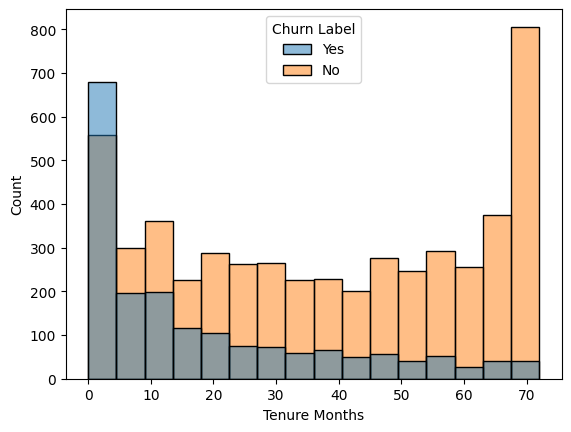

In [15]:
sns.histplot(data=df, x='Tenure Months', hue='Churn Label')
plt.show()

Low Tenure Months has a high change of churned

In [30]:
df.pivot_table(index="Churn", values="Monthly Purchase (Thou. IDR)", aggfunc="mean")

,Monthly Purchase (Thou. IDR)
Churn,
0,79.644661
1,96.773732


Users churn because of monthly payment that they have to spend is more than the un-churned. But does it make sense. Let's take a look at the distribution

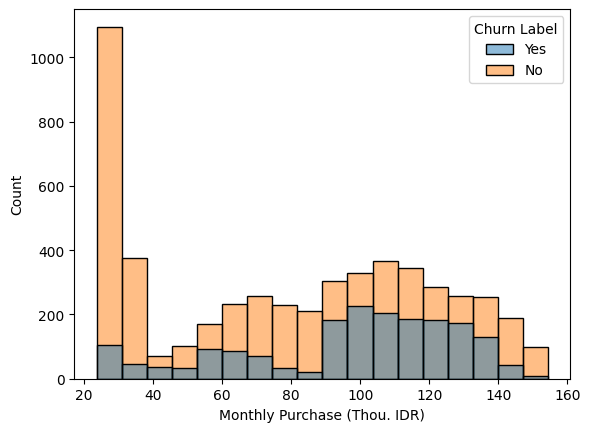

In [16]:
sns.histplot(data=df, x='Monthly Purchase (Thou. IDR)', hue='Churn Label')
plt.show()

Customer also churned for low monhtly purchases, but mose of the churned users spend between Rp 90,000.00 - Rp 140,000.00 a month.